
# **Actividad** – Predicción de diabetes con una red neuronal + Optimización de Arquitectura

**Grupo:** Jiménez Brandon - López Santiago

**Incluye:**  
1. Instalación de librerías.  
2. Carga del dataset `diabetes.csv`.  
3. EDA (conteo de clases, boxplots, matriz de correlación).  
4. Preprocesamiento: `0 → NaN` en columnas clínicas y **imputación por media**.  
5. Separación en _train_ y _test_.  
6. **Modelo baseline**
7. **Entrenamiento con EarlyStopping**.  
8. **Optimización de arquitectura** (capas/neuronas) con **Keras Tuner (Hyperband)**, validación y comparación de métricas.  
9. Respuestas a preguntas planteadas.  
10. Guardado de modelos (baseline y mejor modelo).


In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn tensorboard tensorflow


In [1]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix




## Cargamos el dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_PATH = r"/content/drive/MyDrive/IA/Datasets/diabetes.csv"

diabetes_df = pd.read_csv(DATA_PATH)
diabetes_df.head()


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



### Ploteo del conteo de clases


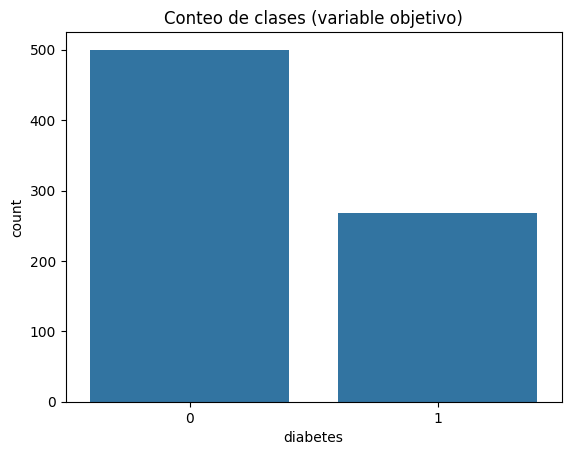

In [7]:
sns.countplot(x='diabetes', data=diabetes_df)
plt.title('Conteo de clases (variable objetivo)')
plt.show()



### Información del DataFrame y distribución (boxplots)


El conjunto de datos de diabetes contiene las siguientes variables:

1. `pregnancies`: Número de veces que la persona ha estado embarazada.
2. `glucose`: Concentración de glucosa en plasma a 2 horas en una prueba oral de tolerancia a la glucosa.
3. `diastolic`: Presión arterial diastólica (mm Hg).
4. `triceps`: Espesor del pliegue de la piel del tríceps (mm).
5. `insulin`: Suero de insulina de 2 horas (mu U/ml).
6. `bmi`: Índice de masa corporal (peso en kg/(altura en m)^2).
7. `dpf`: Pedigree de la función de la diabetes, una función que puntúa la probabilidad de diabetes en función de la historia familiar.
8. `age`: Edad (años).
9. `diabetes`: Variable de clase (0 o 1) donde '1' denota que el paciente tiene diabetes y '0' denota que el paciente no tiene diabetes.

Estas variables se utilizan para predecir si un paciente tiene diabetes o no.

In [10]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    int64  
 2   diastolic    768 non-null    int64  
 3   triceps      768 non-null    int64  
 4   insulin      768 non-null    int64  
 5   bmi          768 non-null    float64
 6   dpf          768 non-null    float64
 7   age          768 non-null    int64  
 8   diabetes     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


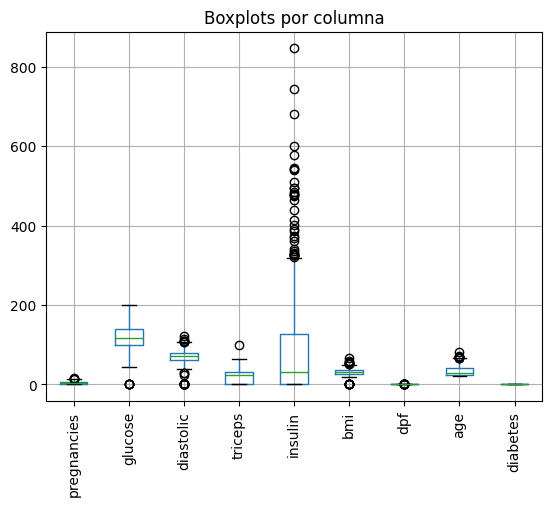

In [11]:
fig, ax = plt.subplots()
diabetes_df.boxplot(ax=ax)
plt.xticks(rotation=90)
plt.title('Boxplots por columna')
plt.show()



### Reemplazamos 0 → NaN (en columnas clínicas) y luego imputamos con la media

Columnas: `glucose`, `diastolic`, `triceps`, `insulin`, `bmi`.


In [12]:
cols_zero_as_nan = ['glucose', 'diastolic', 'triceps', 'insulin', 'bmi']
missing_cols = [c for c in cols_zero_as_nan if c not in diabetes_df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas requeridas en el CSV: {missing_cols}")

diabetes_df[cols_zero_as_nan] = diabetes_df[cols_zero_as_nan].replace(0, np.nan)
diabetes_df.fillna(diabetes_df.mean(numeric_only=True), inplace=True)
diabetes_df.head()


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1



### Matriz de correlación (EDA)


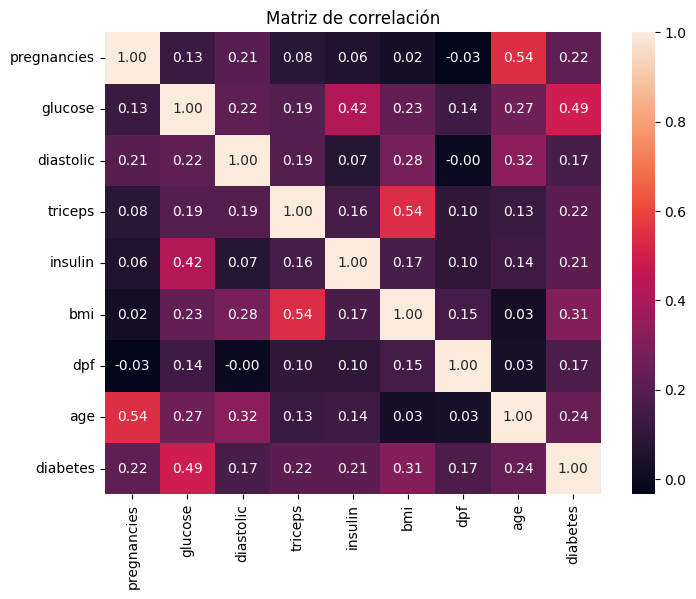

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(diabetes_df.corr(), annot=True, fmt=".2f")
plt.title('Matriz de correlación')
plt.show()



## Preparación de datos para el modelado


In [14]:
# Seleccionamos las columnas predictoras
X_diabetes = diabetes_df.drop('diabetes', axis=1)
X_diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33


In [15]:
# Seleccionamos la columna diabetes como variable objetivo
y_diabetes = diabetes_df['diabetes']
y_diabetes.head()

,diabetes
0,1
1,0
2,1
3,0
4,1


In [22]:
# Dividimos la base de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.3)

## Modelado, compilado, y entrenamiento de una red neuronal

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
# Creamos un modelo secuencial
model = Sequential()

# Añadimos una capa densa con 12 neuronas y función de activación relu. Incluimos la dimensión de entrada con 8 variables predictoras.
model.add(Dense(12, input_dim=8, activation='relu'))

# Añadimos una capa densa con 8 neuronas y función de activación relu
model.add(Dense(8, activation='relu'))

# Añadimos una capa densa con 1 neurona y función de activación sigmoid
model.add(Dense(1, activation='sigmoid'))

In [26]:
# Compilamos el modelo con el optimizador adam, la función de pérdida binary_crossentropy, y las metricas accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Visualizamos un resumen del modelo creado
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221 (884.00 B)

 Trainable params: 221 (884.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Mostramos la forma de la salida del modelo
model.output_shape

(None, 1)

In [29]:
# Entrenamos el modelo con los datos de entrenamiento, especificando el número de épocas y el tamaño del batch
model.fit(X_train, y_train, epochs = 300, batch_size = 32)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6609 - loss: 23.2605
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6593 - loss: 14.0164
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6195 - loss: 6.9749 
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5554 - loss: 2.2056 
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5984 - loss: 1.5799 
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6175 - loss: 1.1932 
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5731 - loss: 1.0577 
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6257 - loss: 0.9608 
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6058 - loss: 0.9550 
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6115 - loss: 0.8621 
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6226 - loss: 0.8483 
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [30]:
# Mostramos los pesos del modelo
model.get_weights()

[array([[-8.56906623e-02, -1.47049323e-01,  1.42264307e-01,
         -1.09746337e+00,  2.54086524e-01,  4.65070128e-01,
         -1.69482350e-01, -7.88524076e-02,  3.28862309e-01,
          2.58773297e-01, -1.93469658e-01, -1.90567046e-01],
        [-1.09007046e-01,  3.02325070e-01, -5.46142049e-02,
          4.66828465e-01, -1.04389511e-01,  9.69467536e-02,
         -9.41228122e-02,  4.85589564e-01,  2.92355299e-01,
         -2.23453715e-01,  1.16713494e-01,  3.19074392e-01],
        [ 1.77600414e-01,  4.54109699e-01,  2.91200429e-01,
         -2.33059987e-01,  2.17184514e-01,  3.38698089e-01,
          4.04817164e-01,  2.26560280e-01,  1.06969737e-01,
         -4.23412323e-01,  3.14537823e-01,  3.79336447e-01],
        [-5.06059349e-01,  2.22197622e-01, -7.51104295e-01,
         -2.11674869e-01, -4.37008262e-01,  5.14107287e-01,
          4.15262222e-01, -5.33437014e-01,  4.12296683e-01,
         -4.06564504e-01,  5.76356500e-02,  3.98095406e-04],
        [-3.74688774e-01, -4.8101669

In [31]:
# Mostramos los bias del modelo
model.layers[0].get_weights()[1]

array([-0.00139651, -0.09351166, -0.23206241,  0.1298986 ,  0.12988333,
       -0.88329595,  0.82507986, -0.09708706, -0.5197996 , -0.14572103,
        0.36556086,  0.56303144], dtype=float32)

In [32]:
# Mostrar la precisión del modelo con los datos de prueba
# El primer valor es la pérdida y el segundo la precisión del modelo con los datos de prueba
scores = model.evaluate(X_test, y_test)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7018 - loss: 0.5637  


[0.5399876236915588, 0.7186146974563599]

In [33]:
# Evaluación del modelo con los datos de entrenamiento
scores = model.evaluate(X_train, y_train, verbose=False)
print("Precisión en la fase de entrenamiento: %.2f%%" % (scores[1]*100))

# Evaluación del modelo con los datos de prueba
scores = model.evaluate(X_test, y_test, verbose=False)
print("Precisión en la fase de prueba: %.2f%%" % (scores[1]*100))

Precisión en la fase de entrenamiento: 75.23%
Precisión en la fase de prueba: 71.86%


## Entrenar con Early Stopping (para evitar overfitting)

In [34]:
import tensorflow as tf

# Compilamos el modelo con el optimizador adam, la función de pérdida binary_crossentropy, y las metricas accuracy
model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics=['accuracy'])

# Definimos la función de parada temprana (early stopping) para evitar el sobreajuste del modelo y restaurar los mejores pesos
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True)

# Entrenamos el modelo con los datos de entrenamiento, especificando el número de épocas, el tamaño del batch y los datos de validación
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6917 - loss: 6.0942 - val_accuracy: 0.6450 - val_loss: 0.6532
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6613 - loss: 0.6501 - val_accuracy: 0.6623 - val_loss: 0.6302
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6280 - loss: 0.6621 - val_accuracy: 0.6797 - val_loss: 0.6130
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6476 - loss: 0.6317 - val_accuracy: 0.7013 - val_loss: 0.6005
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6835 - loss: 0.5946 - val_accuracy: 0.7100 - val_loss: 0.5986
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6598 - loss: 0.6121 - val_accuracy: 0.6970 - val_loss: 0.6280
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6688 - loss: 0.6356 - val_accuracy: 0.6667 - val_loss: 0.6921
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6681 - loss: 0.6271 - val_accuracy: 0.7143 - 

## Evaluación del modelo

In [35]:
# Evaluación del modelo con los datos de entrenamiento
scores = model.evaluate(X_train, y_train, verbose=False)
print("Precisión en la fase de entrenamiento: %.2f%%" % (scores[1]*100))

# Evaluación del modelo con los datos de prueba
scores = model.evaluate(X_test, y_test, verbose=False)
print("Precisión en la fase de prueba: %.2f%%" % (scores[1]*100))

Precisión en la fase de entrenamiento: 73.37%
Precisión en la fase de prueba: 74.46%


In [36]:
# Seleccionamos una persona de la base de datos de prueba para realizar una predicción
persona_de_prueba = X_test.iloc[9]
persona_de_prueba

,239
pregnancies,0.000000
glucose,104.000000
diastolic,76.000000
triceps,29.153420
insulin,155.548223
bmi,18.400000
dpf,0.582000
age,27.000000


In [37]:
# Hacemos una predicción con el modelo entrenado
prediccion = model.predict(persona_de_prueba.values.reshape(1,8))
prediccion

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0.2072575]], dtype=float32)

Comparamos la predicción de un modelo de aprendizaje automático con los datos reales para una "persona de prueba".

- `if prediccion >= 0.5:`: Aquí, `prediccion` es la salida de un modelo de aprendizaje automático. Si la salida es mayor o igual a 0.5, se interpreta como una predicción de que la persona tiene diabetes.

- `print('Según la predicción de la red neuronal: La persona tiene diabetes')`: Esta línea se ejecuta si la condición del `if` es verdadera, es decir, si la predicción es mayor o igual a 0.5.

- `else:`: Esta parte del código se ejecuta si la condición del `if` es falsa, es decir, si la predicción es menor a 0.5.

- `print('Según la predicción de la red neuronal: La persona no tiene diabetes')`: Esta línea se ejecuta si la condición del `if` es falsa.

- `if y_test.iloc[9] == 1:`: Aquí, `y_test` es un DataFrame de pandas que contiene los datos reales. `y_test.iloc[9]` selecciona la décima fila del DataFrame. Si el valor en esta fila es 1, se interpreta como que la persona tiene diabetes.

- `print('Según la base de datos de prueba: La persona tiene diabetes')`: Esta línea se ejecuta si la condición del `if` es verdadera, es decir, si el valor en la décima fila de `y_test` es 1.

- `else:`: Esta parte del código se ejecuta si la condición del `if` es falsa, es decir, si el valor en la décima fila de `y_test` no es 1.

- `print('Según la base de datos de prueba: La persona no tiene diabetes')`: Esta línea se ejecuta si la condición del `if` es falsa.

In [38]:
# Comprobamos si la persona tiene diabetes o no según la predicción
if prediccion >= 0.5:
    print('Según la predicción de la red neuronal: La persona tiene diabetes')
else:
    print('Según la predicción de la red neuronal: La persona no tiene diabetes')

# Comprobamos si la persona tiene diabetes o no según la base de datos
if y_test.iloc[9] == 1:
    print('Según la base de datos de prueba: La persona tiene diabetes')
else:
    print('Según la base de datos de prueba: La persona no tiene diabetes')


Según la predicción de la red neuronal: La persona no tiene diabetes
Según la base de datos de prueba: La persona no tiene diabetes


## Guardamos el modelo para usarlo en producción

In [39]:
# Guardamos el modelo en un archivo
model.save('modelo_diabetes.keras')

In [40]:
# Cargamos el modelo desde el archivo
from tensorflow.keras.models import load_model
modelo_cargado = load_model('modelo_diabetes.keras')

In [41]:
# Hacemos una predicción con el modelo cargado
prediccion_modelo_cargado = modelo_cargado.predict(persona_de_prueba.values.reshape(1,8))

# Comprobamos si la persona tiene diabetes o no según la predicción del modelo cargado
if prediccion_modelo_cargado >= 0.5:
    print('Según la predicción del modelo cargado: La persona tiene diabetes')
else:
    print('Según la predicción del modelo cargado: La persona no tiene diabetes')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Según la predicción del modelo cargado: La persona no tiene diabetes


## **Actividad:** Optimización de la Arquitectura de la Red Neuronal Artificial

#### Objetivo
Trabajar en grupos de 2 para optimizar la arquitectura de una red neuronal utilizando técnicas de búsqueda de hiperparámetros. El objetivo es encontrar los mejores valores para el número de capas y neuronas en cada capa para mejorar el rendimiento del modelo en la predicción de diabetes.

#### Instrucciones

1. **Formar Grupos**: Formar grupos de 1 o 2 estudiantes.

2. **Preparar el Entorno**:
    - Asegúrate de tener instaladas las siguientes librerías:
      ```python
      !pip install tensorflow keras scikit-learn
      ```

3. **Definir el Modelo**:
    - Crear una función que defina el modelo de la red neuronal con parámetros para el **número de capas** y **neuronas en cada capa**.
    - Justificar la selcción de la función de activación de acuerdo a las lecturas realizadas en clase (50%).

4. **Implementar la Búsqueda de Hiperparámetros**:
    - Utilizar `GridSearchCV` de `scikit-learn`, `Keras Tuner`, o `Optuna` para realizar la búsqueda de los mejores hiperparámetros (50%).

5. **Evaluar el Modelo**:
    - Evaluar el modelo con los mejores hiperparámetros encontrados y reportar los resultados. Responder lo siguiente:

1. ¿Qué búsqueda de parámetros usaste?
2. ¿Qué parámetros buscaste?
3. ¿Cómo se diferencian las métricas de tu red neuronal optimizada en relación con la red neuronal sin optimizar?
4. ¿Qué más probarías si tuvieras más tiempo?

In [45]:
%pip -q install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


## Optimización de la Arquitectura de la Red Neuronal

En esta sección mantenemos intacto el **Baseline (histórico)** del trabajo anterior y añadimos un nuevo flujo para la búsqueda de hiperparámetros y comparación:

- **Baseline (histórico)**: es el modelo ya entrenado (variables `model`, `X_train`, `X_test`, etc.).
- **Optimizado (Keras Tuner – Hyperband)**: búsqueda sobre #capas, #neuronas, activación y optimizador/tasa de aprendizaje


In [43]:
# Evaluación del baseline actual para comparar (no reentrena)
baseline_train_loss, baseline_train_acc = model.evaluate(X_train, y_train, verbose=False)
baseline_test_loss,  baseline_test_acc  = model.evaluate(X_test,  y_test,  verbose=False)
print(f"[Baseline] Acc(train) = {baseline_train_acc:.4f} | Acc(test) = {baseline_test_acc:.4f}")


[Baseline] Acc(train) = 0.7337 | Acc(test) = 0.7446


## Búsqueda de hiperparámetros con Keras Tuner

In [46]:
import tensorflow as tf, keras, keras_tuner as kt
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

tf.keras.utils.set_random_seed(42)

input_dim = X_train.shape[1]
assert input_dim == 8, f"Se esperaban 8 features, llegaron {input_dim}."


In [47]:
def build_model(hp: kt.HyperParameters) -> keras.Model:
    activation = hp.Choice("activation", ["relu", "tanh"])
    n_layers   = hp.Int("n_layers", min_value=1, max_value=3, step=1)

    # Capa de entrada
    inputs = keras.Input(shape=(input_dim,), name="inputs")
    x = inputs

    for i in range(n_layers):
        units = hp.Int(f"units_l{i+1}", min_value=8, max_value=64, step=8)
        x = layers.Dense(units, activation=activation, name=f"dense_{i+1}")(x)
        # Regularización
        if hp.Boolean(f"use_dropout_l{i+1}", default=False):
            rate = hp.Choice(f"dropout_rate_l{i+1}", [0.1, 0.2, 0.3])
            x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)
    m = keras.Model(inputs=inputs, outputs=outputs, name="mlp_diabetes_tuned")

    # Optimizador y LR (evitamos lr=1e-2 con Adam)
    opt_name = hp.Choice("optimizer", ["adam", "sgd"])
    if opt_name == "adam":
        lr = hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4])
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        lr = hp.Choice("sgd_lr", [1e-2, 5e-3, 1e-3])
        momentum = hp.Choice("sgd_momentum", [0.0, 0.9])
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

    m.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return m


### Justificación de la **función de activación**

- **ReLU:** es la más usada hoy en día porque es simple y rápida. Hace que el entrenamiento avance más rápido y evita que los gradientes se vuelvan casi cero, lo cual suele frenar el aprendizaje. Es muy efectiva cuando los datos ya están normalizados o escalados, como en este caso.  

- **Tanh:** a diferencia de ReLU, sus valores van de -1 a 1, lo que centra las activaciones en torno a cero. Esto puede ayudar al modelo a aprender mejor cuando los datos tienen relaciones que se distribuyen en positivo y negativo, lo cual es común en variables médicas como presiones, niveles de glucosa o índices que pueden variar bastante.  

En este dataset no había un argumento fuerte para elegir solo una de entrada. Por eso decidimos probar **ReLU y Tanh**, y dejar que la validación mostrara en la práctica cuál se ajustaba mejor al problema.  

## Ejecutar Hyperband sin usar el test como validación

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

In [49]:
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_epochs=80,
    factor=3,
    seed=42,
    directory="kt_diabetes",
    project_name="hyperband_mlp"
)

In [50]:
print("Búsqueda Hyperband")
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Trial 90 Complete [00h 00m 12s]
val_accuracy: 0.6388888955116272

Best val_accuracy So Far: 0.7685185074806213
Total elapsed time: 00h 05m 47s


In [51]:
print("\nTop trials")
tuner.results_summary(num_trials=5)


Top trials
Results summary
Results in kt_diabetes/hyperband_mlp
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0050 summary
Hyperparameters:
activation: tanh
n_layers: 1
units_l1: 48
use_dropout_l1: True
optimizer: sgd
learning_rate: 0.001
sgd_lr: 0.005
sgd_momentum: 0.0
units_l2: 64
use_dropout_l2: True
dropout_rate_l1: 0.2
dropout_rate_l2: 0.1
units_l3: 64
use_dropout_l3: True
dropout_rate_l3: 0.2
tuner/epochs: 80
tuner/initial_epoch: 27
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Score: 0.7685185074806213

Trial 0024 summary
Hyperparameters:
activation: tanh
n_layers: 1
units_l1: 56
use_dropout_l1: False
optimizer: sgd
learning_rate: 0.0001
sgd_lr: 0.001
sgd_momentum: 0.9
units_l2: 56
use_dropout_l2: True
dropout_rate_l1: 0.1
dropout_rate_l2: 0.1
units_l3: 64
use_dropout_l3: True
dropout_rate_l3: 0.1
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.75

Trial 0034 summary
Hyperparameters:
activation: tanh
n_layers

## Entrenar el mejor modelo y evaluar vs baseline original

In [52]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [53]:
hist_best = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4112 - loss: 0.9403 - val_accuracy: 0.5648 - val_loss: 0.6591
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5681 - loss: 0.6764 - val_accuracy: 0.6481 - val_loss: 0.6450
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5605 - loss: 0.7147 - val_accuracy: 0.6667 - val_loss: 0.6354
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5953 - loss: 0.6730 - val_accuracy: 0.6759 - val_loss: 0.6259
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5723 - loss: 0.6837 - val_accuracy: 0.6481 - val_loss: 0.6215
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6125 - loss: 0.7025 - val_accuracy: 0.6852 - val_loss: 0.6230
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6086 - loss: 0.6484 - val_accuracy: 0.6759 - val_loss: 0.6200
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5880 - loss: 0.6789 - val_accuracy: 0.72

In [54]:
# Evaluación final en test (que se mantuvo oculto durante la búsqueda)
best_train_loss, best_train_acc = best_model.evaluate(X_train, y_train, verbose=False)
best_test_loss,  best_test_acc  = best_model.evaluate(X_test,  y_test,  verbose=False)

print(f"[Mejor modelo] Acc(train) = {best_train_acc:.4f} | Acc(test) = {best_test_acc:.4f}")
print(f"[Comparación]  Baseline vs Tuned (test): {baseline_test_acc:.4f} -> {best_test_acc:.4f}")

[Mejor modelo] Acc(train) = 0.6853 | Acc(test) = 0.6970
[Comparación]  Baseline vs Tuned (test): 0.7446 -> 0.6970


In [58]:
# Métricas
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_test_proba = best_model.predict(X_test).ravel()
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print("\nAccuracy (test): ", accuracy_score(y_test, y_test_pred))
print("\nF1 (test, clase 1):", f1_score(y_test, y_test_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_test_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_test_pred, digits=4))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Accuracy (test):  0.696969696969697

F1 (test, clase 1): 0.33962264150943394

Matriz de confusión:
 [[143   7]
 [ 63  18]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.6942    0.9533    0.8034       150
           1     0.7200    0.2222    0.3396        81

    accuracy                         0.6970       231
   macro avg     0.7071    0.5878    0.5715       231
weighted avg     0.7032    0.6970    0.6408       231



In [59]:
# Guardar
best_model.save("modelo_diabetes_opt.keras")
print("Hiperparámetros óptimos:")
for k, v in best_hp.values.items():
    print(f" - {k}: {v}")

Hiperparámetros óptimos:
 - activation: tanh
 - n_layers: 1
 - units_l1: 48
 - use_dropout_l1: True
 - optimizer: sgd
 - learning_rate: 0.001
 - sgd_lr: 0.005
 - sgd_momentum: 0.0
 - units_l2: 64
 - use_dropout_l2: True
 - dropout_rate_l1: 0.2
 - dropout_rate_l2: 0.1
 - units_l3: 64
 - use_dropout_l3: True
 - dropout_rate_l3: 0.2
 - tuner/epochs: 80
 - tuner/initial_epoch: 27
 - tuner/bracket: 3
 - tuner/round: 3
 - tuner/trial_id: 0047


## Predicción con el modelo optimizado

In [60]:
# Probamos el modelo optimizado (best_model) con la misma persona de prueba
pred_opt = best_model.predict(persona_de_prueba.values.reshape(1, 8))
pred_opt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


array([[0.34048474]], dtype=float32)

In [61]:
# Interpretación con el mismo umbral 0.5
if pred_opt >= 0.5:
    print('Según la predicción del MODELO OPTIMIZADO: La persona TIENE diabetes')
else:
    print('Según la predicción del MODELO OPTIMIZADO: La persona NO tiene diabetes')

# Verificación con la etiqueta real
if y_test.iloc[9] == 1:
    print('Según la base de datos de prueba: La persona TIENE diabetes')
else:
    print('Según la base de datos de prueba: La persona NO tiene diabetes')


Según la predicción del MODELO OPTIMIZADO: La persona NO tiene diabetes
Según la base de datos de prueba: La persona NO tiene diabetes


In [62]:
# Cargamos el modelo optimizado
from tensorflow.keras.models import load_model
modelo_opt_cargado = load_model('modelo_diabetes_opt.keras')


In [63]:
# Predicción con el modelo optimizado cargado
pred_opt_cargado = modelo_opt_cargado.predict(persona_de_prueba.values.reshape(1, 8))

if pred_opt_cargado >= 0.5:
    print('Según la predicción del MODELO OPTIMIZADO CARGADO: La persona TIENE diabetes')
else:
    print('Según la predicción del MODELO OPTIMIZADO CARGADO: La persona NO tiene diabetes')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Según la predicción del MODELO OPTIMIZADO CARGADO: La persona NO tiene diabetes


## Comparación rápida: Baseline vs Optimizado (en test)

In [73]:
# Evaluación del baseline actual para comparar
baseline_train_loss, baseline_train_acc = model.evaluate(X_train, y_train, verbose=False)
baseline_test_loss,  baseline_test_acc  = model.evaluate(X_test,  y_test,  verbose=False)

print("Exactitud del MODELO BASELINE en entrenamiento: {:.2f}%".format(baseline_train_acc*100))
print("Exactitud del MODELO BASELINE en prueba:        {:.2f}%".format(baseline_test_acc*100))

Exactitud del MODELO BASELINE en entrenamiento: 73.37%
Exactitud del MODELO BASELINE en prueba:        74.46%


In [72]:
# Evaluación del modelo optimizado (best_model)
scores_train_opt = best_model.evaluate(X_train, y_train, verbose=False)
scores_test_opt  = best_model.evaluate(X_test,  y_test,  verbose=False)

print("Exactitud del MODELO OPTIMIZADO en entrenamiento: {:.2f}%".format(scores_train_opt[1]*100))
print("Exactitud del MODELO OPTIMIZADO en prueba:        {:.2f}%".format(scores_test_opt[1]*100))

Exactitud del MODELO OPTIMIZADO en entrenamiento: 68.53%
Exactitud del MODELO OPTIMIZADO en prueba:        69.70%


In [74]:
delta = best_test_acc - baseline_test_acc
print("Diferencia (Optimizado - Baseline): {:+.4f}".format(delta))

Diferencia (Optimizado - Baseline): -0.0476


## Respuestas

### ¿Qué búsqueda de parámetros usaste?
Usamos **Keras Tuner con Hyperband**. Este método prueba muchas configuraciones de la red neuronal y va descartando las que funcionan peor. Al final se enfoca en las que tienen mejores resultados en validación.

### ¿Qué parámetros buscaste?
Exploramos varias combinaciones de hiperparámetros que afectan directamente la arquitectura y el entrenamiento del modelo:

- **Número de capas ocultas**: probamos entre 1 y 3.

  Las capas ocultas son donde la red procesa la información y aprende patrones. Con más capas se puede captar mayor complejidad, pero también aumenta el riesgo de sobreajuste.

- **Neuronas por capa**: valores desde 8 hasta 64.  

  Cada neurona procesa una parte de la información. Más neuronas permiten detectar más detalles, aunque demasiadas pueden hacer que el modelo memorice en lugar de generalizar.

- **Funciones de activación**: tanto `ReLU` como `tanh`, que son comunes en MLP.  

  Estas funciones determinan cómo se transforman las señales dentro de la red:  
  - `ReLU`: rápida y eficiente, evita problemas de gradientes y suele ser la más usada.  
  - `tanh`: produce valores entre -1 y 1, lo que ayuda a mantener un balance entre positivos y negativos.



- **Dropout**: activado o no, con tasas de 0.1, 0.2 y 0.3 para evitar sobreajuste.  

  Sirve para reducir el sobreajuste. Durante el entrenamiento apaga algunas neuronas de forma aleatoria, obligando al modelo a no depender demasiado de unas pocas conexiones.


- **Optimizador y tasa de aprendizaje**:  
  - `Adam` con tasas 0.001, 0.0005 y 0.0001. (ajusta automáticamente la forma en que actualiza los pesos y suele converger rápido)
  - `SGD` con tasas 0.01, 0.005 y 0.001, con y sin momentum de 0.9.  

    La tasa de aprendizaje (lr) marca el tamaño del paso que da la red al aprender:
    
    - pasos pequeños = más lento pero preciso
    
    - pasos grandes = más rápido pero con riesgo de inestabilidad


El mejor modelo encontrado por la búsqueda fue:
- 1 capa oculta con 48 neuronas.  
- Activación **tanh**.  
- Optimizador **SGD** con tasa de aprendizaje 0.001.  
- Dropout de 0.2 en esa capa oculta.  


### ¿Cómo se diferencian las métricas de tu red neuronal optimizada en relación con la red neuronal sin optimizar?

| Modelo     | Exactitud en entrenamiento | Exactitud en prueba |
|------------|-----------------------------|----------------------|
| Baseline   | 73.37%                      | 74.46%               |
| Optimizado | 68.53%                      | 69.70%               |

**Diferencia en prueba (Optimizado – Baseline): –4.76%**

En este caso, el modelo optimizado **no superó al baseline**. Lo que ocurrió es que la búsqueda eligió un modelo más simple (con menos capas y neuronas). Esto redujo el riesgo de sobreajuste, pero también hizo que la red perdiera parte de la capacidad de generalizar en el conjunto de prueba, y eso explicaría la caída en el accuracy.


### ¿Qué más probarías si tuvieras más tiempo?
- Probar más neuronas y más capas en la búsqueda.  
- Probar otras formas de regularización como L1 y L2 además del Dropout.  
- Usar métricas más adecuadas para datos desbalanceados, como **F1** o **AUC**, en lugar de solo exactitud.    
- Dar más épocas y repeticiones a la búsqueda para explorar mejor.  
- Usar otros buscadores como **Optuna**, para probar configuraciones de forma más inteligente y encontrar mejores combinaciones.